# <span style="color:STEELBLUE">**Set Up**</span>

## Import Libraries

In [392]:
import pandas as pd
import numpy as np
from numpy.fft import fft, fftfreq, ifft, fft2, ifft2, fftshift
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

## Import Data

Hourly Timestep \
Elevation NAVD88 \
Time GMT \
Units Meters

In [2]:
CHICK = pd.read_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/02042500_Chick_Dichge_GH.xlsx")
df_CHICK = pd.DataFrame(CHICK)

CBBT = pd.read_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638901_CBBT_season_combo.xlsx")
df_CBBT = pd.DataFrame(CBBT)

SP = pd.read_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638610_SP_season_combo.xlsx")
df_SP = pd.DataFrame(SP)

## Create Pandas Timestamps as DateTime Index

This creates a powerful date-time index that Pandas relies upon for time series functionality \
Declaring this will keep all timestamps consistent across all datasets \
We will also set the dataframe index to be the timestamp so that we can use Pandas time-based indexing functionality \
With this functionality, we can select slices of time intervals using .loc (inclusive of endpoints) --> df_CBBT.loc['2018-08-01':'2018-08-31']

In [3]:
df_CHICK['Timestamp'] = pd.to_datetime(df_CHICK['Time'])
df_CBBT['Timestamp'] = pd.to_datetime(df_CBBT['Time'])
df_SP['Timestamp'] = pd.to_datetime(df_SP['Time'])

In [4]:
#save a copy of timstamp as x for plotting?
x_SP = df_SP['Timestamp']
x_CBBT = df_CBBT['Timestamp']

In [5]:
df_CHICK = df_CHICK.set_index(['Timestamp'])
df_CBBT = df_CBBT.set_index(['Timestamp'])
df_SP = df_SP.set_index(['Timestamp'])

## Drop unnecesary columns

In [6]:
# print(df_SP.columns)
# print(df_CBBT.columns)
# print(df_CHICK.columns)

In [7]:
df_SP.drop(['Time', 'Date', 'Time_GMT', 'Date_ID', 'Time_ID', 'ID'], axis=1, inplace=True)
df_CBBT.drop(['Time', 'Date', 'Time_GMT', 'Date_ID', 'Time_ID', 'ID'], axis=1, inplace=True)
df_CHICK.drop(['Time', 'TIME_GMT', 'ID'], axis=1, inplace=True)

# <span style="color:STEELBLUE">**Fast Fourier Transform**</span>

Discrete Fourier transform separates its input into components that contribute at discrete frequencies \
Discretized input to the transform is customarily referred to as a signal, which exists in the time domain. The output is called a spectrum or transform and exists in the frequency domain.

### Discrete Fast Fourier Transform (DFFT)
![alt text](DFFT.png "Title") \
![alt text](SingleFreqComp.png "Title")

### Inverse DFFT 
![alt text](IDFFT.png "Title")

Method (https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/_) 

Calculate fast fourier transform of the total water level signal \
fft(a[, n, axis, norm])	Compute the one-dimensional discrete Fourier Transform.

In [8]:
####### Consider adding an n to be the length of the dataset......it might be zero padding my output

In [9]:
fft_vals_SP = fft(df_SP['N_Obs_m'])

fft_vals_CBBT = fft(df_CBBT['N_Obs_m'])

### Power Spectral Density
![alt text](PSD.png "Title")

“How much power” is contained in the frequency interval between f and f C df \
Get the power spectral density by taking the square of the absolute value of fft_vals

In [10]:
psd_SP = np.abs(fft_vals_SP) ** 2

psd_CBBT = np.abs(fft_vals_CBBT) ** 2

Calculate the frequencies \
Day as frequency unit, aka frequency of 1 corresponsd to 1 day \
fftfreq(n[, d])	Return the Discrete Fourier Transform sample frequencies.

Frequency unit is the inverse of samping rate
so my samping rate is 1 per hour, 0.16666 per minute or 0.00027777 per second, 24 per day

In [11]:
freqs_SP = fftfreq(len(psd_SP), 1/24.0)
mask_SP = freqs_SP > 0

freqs_CBBT = fftfreq(len(psd_CBBT), 1.0/24.)
mask_CBBT = freqs_CBBT > 0

## Plots

In [12]:
y_SP = df_SP['N_Obs_m']
y_CBBT = df_CBBT['N_Obs_m']

In [13]:
sns.set(rc={'figure.figsize':(11, 4)})

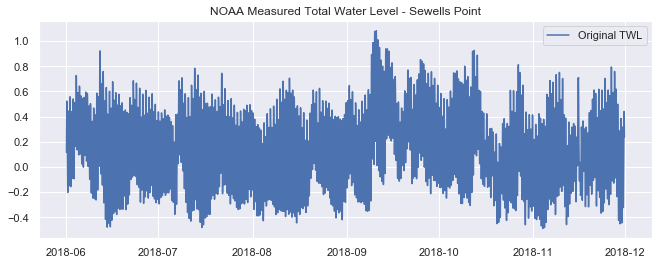

In [14]:
plt.figure(1)
plt.title ('NOAA Measured Total Water Level - Sewells Point')
plt.plot(x_SP, y_SP, label = 'Original TWL')
plt.legend()

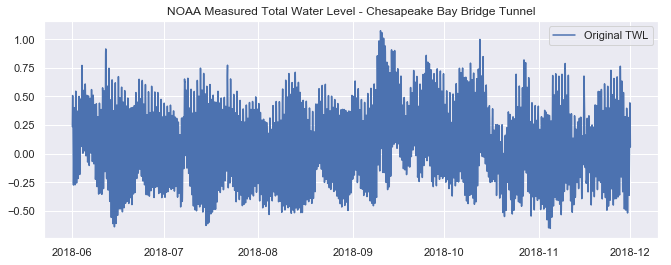

In [15]:
plt.figure(1)
plt.title ('NOAA Measured Total Water Level - Chesapeake Bay Bridge Tunnel')
plt.plot(x_CBBT, y_CBBT, label = 'Original TWL')
plt.legend()

Power spectral density of signal as a function of the frequency (in unit of 1/day), cycles per day \
Lograithmic scale for y axis (decibels)

Text(0,0.5,'PSD (dB)')

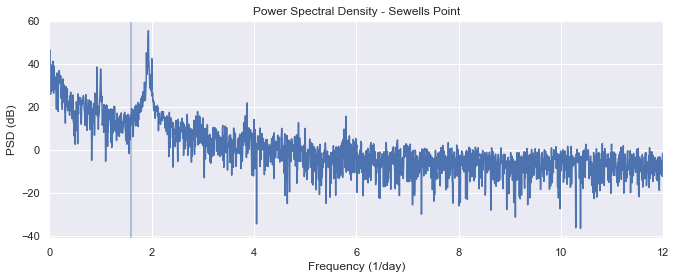

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(freqs_SP[mask_SP], 10 * np.log10(psd_SP[mask_SP]))
plt.title ('Power Spectral Density - Sewells Point')
plt.axvline(1.6, alpha = 0.5)
ax.set_xlim(0, 12)
ax.set_xlabel('Frequency (1/day)')
ax.set_ylabel('PSD (dB)')


Text(0,0.5,'PSD (dB)')

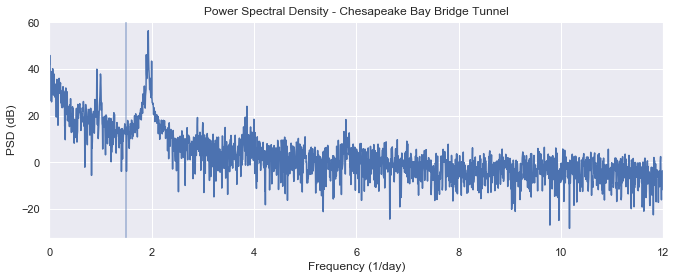

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(freqs_CBBT[mask_CBBT], 10 * np.log10(psd_CBBT[mask_CBBT]))
plt.title ('Power Spectral Density - Chesapeake Bay Bridge Tunnel')
plt.axvline(1.5, alpha = 0.5)
ax.set_xlim(0, 12)
ax.set_xlabel('Frequency (1/day)')
ax.set_ylabel('PSD (dB)')

Cut out frequencies higher than the fundemental frequency using the daily frequency measure

In [203]:
#setting all values above line to 0, want to eliminate the energy from the tides

fft_bis_SP = fft_vals_SP.copy()
fft_bis_SP[np.abs(freqs_SP) > 1.6] = 0

fft_bis_CBBT = fft_vals_CBBT.copy()
fft_bis_CBBT[np.abs(freqs_CBBT) > 1.5] = 0

ifft(a[, n, axis, norm])	Compute the one-dimensional inverse discrete Fourier Transform.

In [181]:
detide_SP = np.real(ifft(fft_bis_SP))

detide_CBBT = np.real(ifft(fft_bis_CBBT))


In [182]:
# plt.figure(1)
# plt.title ('NOAA Measured Total Water Level')
# plt.plot(x, y, label = 'Original TWL')
# plt.legend()

Text(0,0.5,'Water Level (m)')

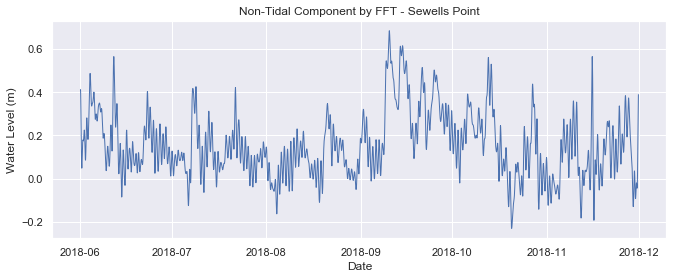

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(x_SP, detide_SP, linewidth = 1)
ax.set_title('Non-Tidal Component by FFT - Sewells Point')
ax.set_xlabel('Date')
ax.set_ylabel('Water Level (m)')

Text(0,0.5,'Water Level (m)')

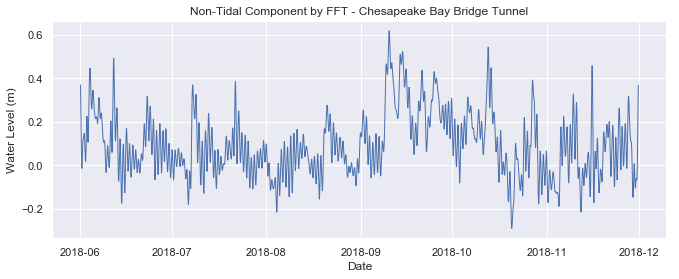

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(x_CBBT, detide_CBBT, linewidth = 1)
ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel')
ax.set_xlabel('Date')
ax.set_ylabel('Water Level (m)')

## Add manual FFT detiding to original dataframe

In [185]:
df_SP['man_detide'] = detide_SP

df_CBBT['man_detide'] = detide_CBBT

## Export

In [186]:
# df_SP.to_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638610_SP_season_combo_FFT.xlsx")

# df_CBBT.to_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638901_CBBT_season_combo_FFT.xlsx")

# <span style="color:STEELBLUE">**Figures - Non-Tidal Residuals**</span>


Test out different figures we can make

In [187]:
sns.set(rc={'figure.figsize':(11, 4)})


## Individual line plots

In [188]:
# df_SP['T_NTR_m'].plot(linewidth=0.5);

In [189]:
# df_SP['N_Obs_min_Pred_m'].plot(linewidth=0.5);

## Subplots using dots as markers

In [190]:
# cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m']
# axes = df_SP[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
# for ax in axes:
#     ax.set_ylabel('Water Elevation (m)')

## Subplots using lines as markers

### Sewells Point

Text(0.05,0.5,'Water Elevation (m)')

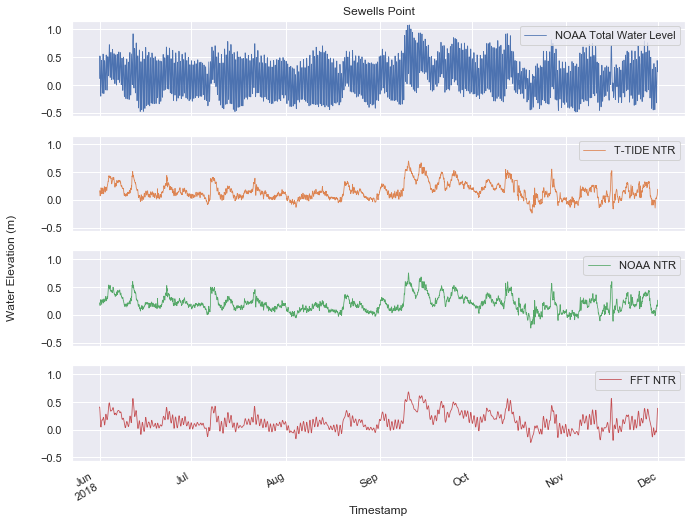

In [206]:
cols_plot = ['N_Obs_m','T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
axes = df_SP[cols_plot].plot(linewidth=0.8, figsize=(11, 9), subplots=True, sharey = True, sharex = True)

axes[0].legend(['NOAA Total Water Level'], loc = 'best')
axes[1].legend(['T-TIDE NTR'], loc = 'best')
axes[2].legend(['NOAA NTR'],loc = 'best')
axes[3].legend(['FFT NTR'], loc = 'best')



axes[0].set_title('Sewells Point')

fig = axes[0].figure
fig.text(0.05,0.5, 'Water Elevation (m)', ha="center", va="center", rotation=90)



### Chesapeake Bay Bridge Tunnel

Text(0.05,0.5,'Water Elevation (m)')

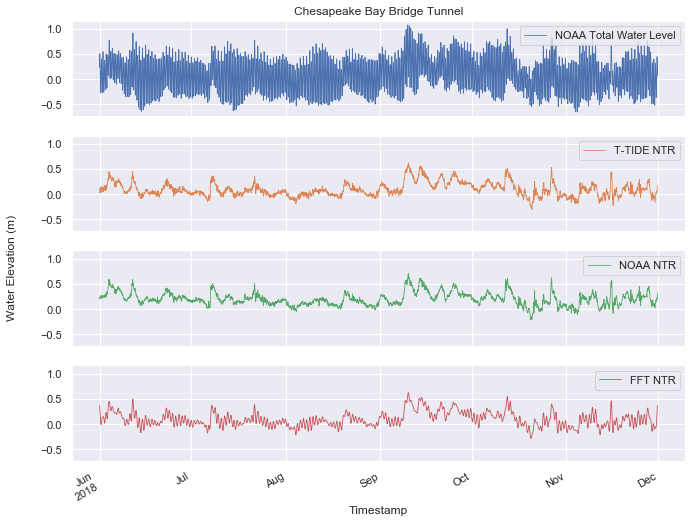

In [209]:
cols_plot = ['N_Obs_m','T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
axes = df_CBBT[cols_plot].plot(linewidth=0.8, figsize=(11, 9), subplots=True, sharey = True, sharex = True)

axes[0].legend(['NOAA Total Water Level'], loc = 'upper right')
axes[1].legend(['T-TIDE NTR'], loc = 'best')
axes[2].legend(['NOAA NTR'], loc = 'best')
axes[3].legend(['FFT NTR'], loc = 'best')

axes[0].set_title('Chesapeake Bay Bridge Tunnel')

fig = axes[0].figure
fig.text(0.05,0.5, 'Water Elevation (m)', ha="center", va="center", rotation=90)

## Comparing 2 datasets on one column, looking at just Hurricane Michael Timeframe

### Sewell's Point

In [193]:
# cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m']
# ax = df_SP[cols_plot].loc['2018-10-05':'2018-10-14'].plot(linestyle='-')
# ax.set_ylabel('Water Elevation (m)')

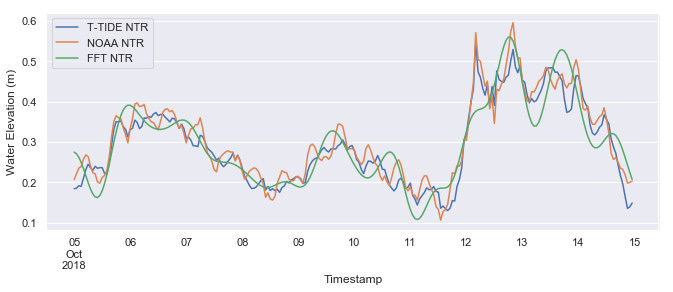

In [211]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_SP[cols_plot].loc['2018-10-05':'2018-10-14'].plot(linestyle='-')
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'], loc = 'upper left')

### Chesapeake Bay Bridge Tunnel

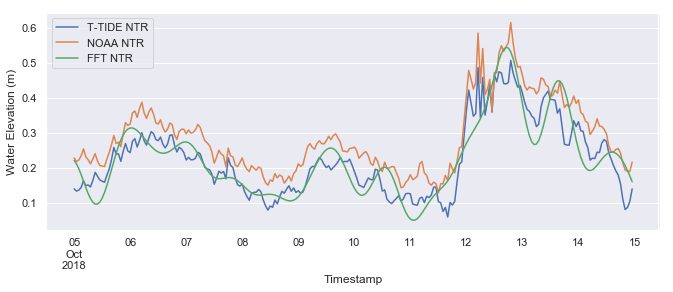

In [212]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_CBBT[cols_plot].loc['2018-10-05':'2018-10-14'].plot(linestyle='-')
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'], loc = 'upper left')

## Same plot looking at whole season

### Sewells Point

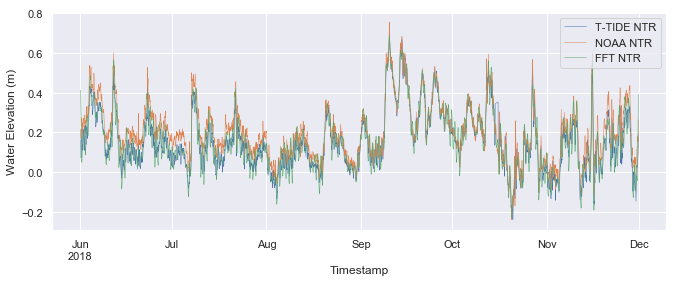

In [196]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_SP[cols_plot].plot(linestyle='-', linewidth=0.5)
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'])

### Chespeake Bay Bridge Tunnel

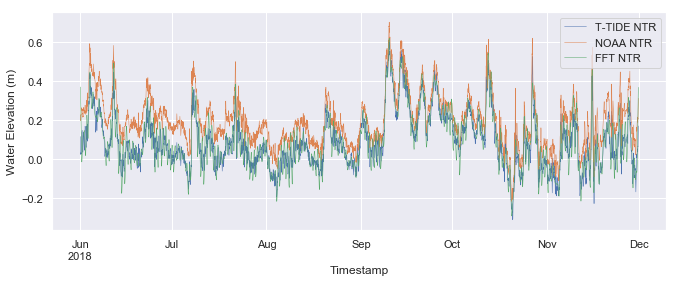

In [197]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_CBBT[cols_plot].plot(linestyle='-', linewidth=0.5)
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'])

# <span style="color:STEELBLUE">**Correlations - Coastal/Riverine**</span>

### Clean

In [198]:
df_CHICK.rename(columns = {'Gauge_Height_m ': 'G_HT_m', 'Discharge_m3ps': 'Disch_m3ps'}, inplace=True)

In [199]:
df_SP = df_SP.merge(df_CHICK, right_index=True, left_index=True, how='left')
df_CBBT = df_CBBT.merge(df_CHICK, right_index=True, left_index=True, how='left')

### Visualize

In [200]:
df_CBBT.columns

Index(['N_Pred_m', 'N_Obs_m', 'N_Obs_min_Pred_m', 'T_Pred_m', 'T_NTR_m',
       'man_detide', 'Disch_m3ps', 'G_HT_m'],
      dtype='object')

Text(0.05,0.5,'Water Elevation (m)')

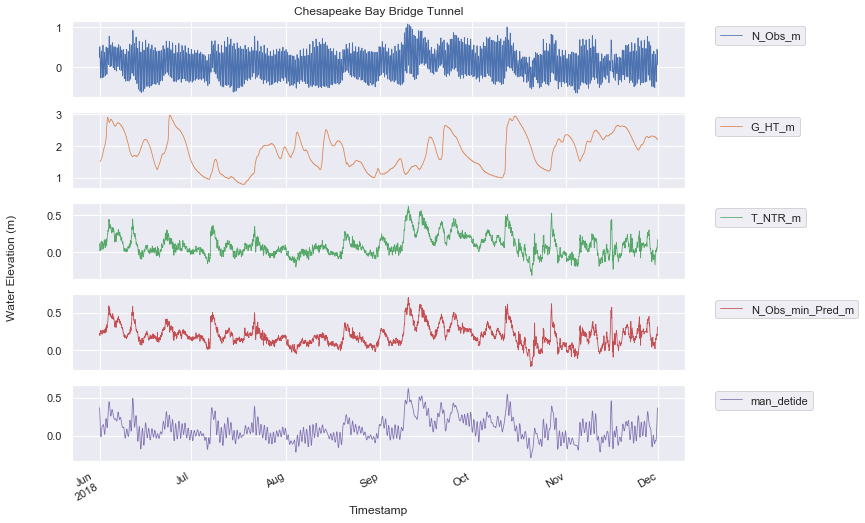

In [240]:
cols_plot = ['N_Obs_m', 'G_HT_m', 'T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
axes = df_CBBT[cols_plot].plot(linewidth=0.8, figsize=(11, 9), subplots=True, sharey = False, sharex = True)

axes[0].legend(['NOAA Total Water Level'])
axes[1].legend(['Chickahominy Gauge Height'])
axes[2].legend(['T-TIDE NTR'])
axes[3].legend(['NOAA NTR'])
axes[4].legend(['FFT NTR'])

axes[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[1].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[2].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[3].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[4].legend(bbox_to_anchor=(1.04,1), loc="upper left")

axes[0].set_title('Chesapeake Bay Bridge Tunnel')

fig = axes[0].figure
fig.text(0.05,0.5, 'Water Elevation (m)', ha="center", va="center", rotation=90)

Text(0.05,0.5,'Water Elevation (m)')

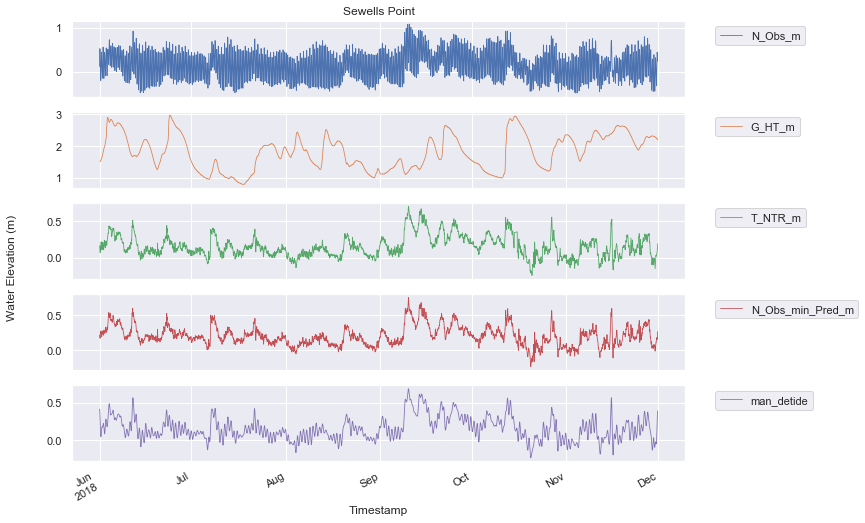

In [241]:
cols_plot = ['N_Obs_m', 'G_HT_m', 'T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
axes = df_SP[cols_plot].plot(linewidth=0.8, figsize=(11, 9), subplots=True, sharey = False, sharex = True)

axes[0].legend(['NOAA Total Water Level'])
axes[1].legend(['Chickahominy Gauge Height'])
axes[2].legend(['T-TIDE NTR'])
axes[3].legend(['NOAA NTR'])
axes[4].legend(['FFT NTR'])

axes[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[1].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[2].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[3].legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes[4].legend(bbox_to_anchor=(1.04,1), loc="upper left")

axes[0].set_title('Sewells Point')

fig = axes[0].figure
fig.text(0.05,0.5, 'Water Elevation (m)', ha="center", va="center", rotation=90)

### Global Pearson Correlation

In [242]:
df_CBBT.columns

Index(['N_Pred_m', 'N_Obs_m', 'N_Obs_min_Pred_m', 'T_Pred_m', 'T_NTR_m',
       'man_detide', 'Disch_m3ps', 'G_HT_m'],
      dtype='object')

In [243]:
SP_NOAA_pearson_r = df_SP.corr().iloc[2,7]
SP_T_pearson_r = df_SP.corr().iloc[4,7]
SP_Man_pearson_r = df_SP.corr().iloc[5,7]

CBBT_NOAA_pearson_r = df_CBBT.corr().iloc[2,7]
CBBT_T_pearson_r = df_CBBT.corr().iloc[4,7]
CBBT_Man_pearson_r = df_CBBT.corr().iloc[5,7]

In [427]:
def overall_pearson_plot(df, cols_plot, r):
    f,ax=plt.subplots(figsize=(7,3))
    df[cols_plot].rolling(window=24,center=True).median().plot(ax=ax)
    ax.set(xlabel='Time',ylabel='Height above NAVD88 m')
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    ax.set(title=f"Overall Pearson r = {np.round(r,2)}");

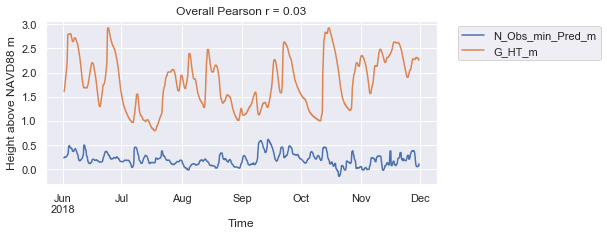

In [428]:
cols_plot = ['N_Obs_min_Pred_m', 'G_HT_m']
overall_pearson_plot(df_SP, cols_plot, SP_NOAA_pearson_r)

In [262]:
# cols_plot = ['T_NTR_m', 'G_HT_m']
# overall_pearson_plot(df_SP, cols_plot, SP_T_pearson_r)

In [263]:
# cols_plot = ['man_detide', 'G_HT_m']
# overall_pearson_plot(df_SP, cols_plot, SP_Man_pearson_r)

In [264]:
# cols_plot = ['N_Obs_min_Pred_m', 'G_HT_m']
# overall_pearson_plot(df_CBBT, cols_plot, CBBT_NOAA_pearson_r)

In [265]:
# cols_plot = ['T_NTR_m', 'G_HT_m']
# overall_pearson_plot(df_CBBT, cols_plot, CBBT_T_pearson_r)

In [266]:
# cols_plot = ['man_detide', 'G_HT_m']
# overall_pearson_plot(df_CBBT, cols_plot, CBBT_Man_pearson_r)

### Pearson Local Correlation

In [429]:
r_window_size = 400

SP_NOAA_rolling_r = df_SP['N_Obs_min_Pred_m'].rolling(window=r_window_size, center=True).corr(df_SP['G_HT_m'])
SP_T_rolling_r = df_SP['T_NTR_m'].rolling(window=r_window_size, center=True).corr(df_SP['G_HT_m'])
SP_Man_rolling_r = df_SP['man_detide'].rolling(window=r_window_size, center=True).corr(df_SP['G_HT_m'])

CBBT_NOAA_rolling_r = df_SP['N_Obs_min_Pred_m'].rolling(window=r_window_size, center=True).corr(df_SP['G_HT_m'])
CBBT_T_rolling_r = df_SP['T_NTR_m'].rolling(window=r_window_size, center=True).corr(df_SP['G_HT_m'])
CBBT_Man_rolling_r = df_SP['man_detide'].rolling(window=r_window_size, center=True).corr(df_SP['G_HT_m'])





In [430]:
def rolling_pearson_plot(df, cols_plot, rolling_r, title):
    f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
    df[cols_plot].rolling(window=30,center=True).median().plot(ax=ax[0])
    ax[0].set(xlabel='Frame',ylabel='Height above NAVD88 m')
    rolling_r.plot(ax=ax[1])
    ax[1].set(xlabel='Frame',ylabel='Pearson r')
    plt.suptitle(title)
    
    ax[0].axvspan('2018-09-13 01:00:00', '2018-09-15 01:00:00', alpha=0.2)
    ax[1].axvspan('2018-09-13 01:00:00', '2018-09-15 01:00:00', alpha=0.2)
    ax[0].axvspan('2018-10-11 01:00:00', '2018-10-15 01:00:00', alpha=0.2)
    ax[1].axvspan('2018-10-11 01:00:00', '2018-10-15 01:00:00', alpha=0.2)
    
    ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")


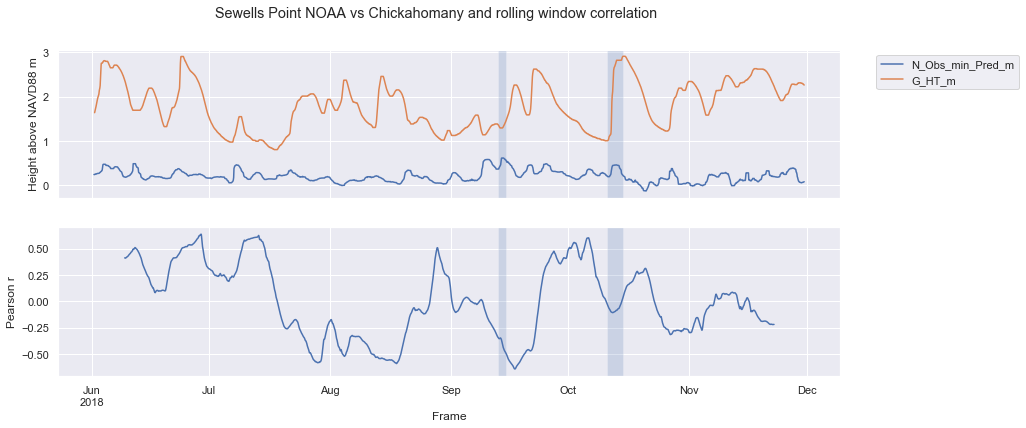

In [431]:
cols_plot = ['N_Obs_min_Pred_m', 'G_HT_m']
title = "Sewells Point NOAA vs Chickahomany and rolling window correlation"
rolling_pearson_plot(df_SP, cols_plot, SP_NOAA_rolling_r, title)

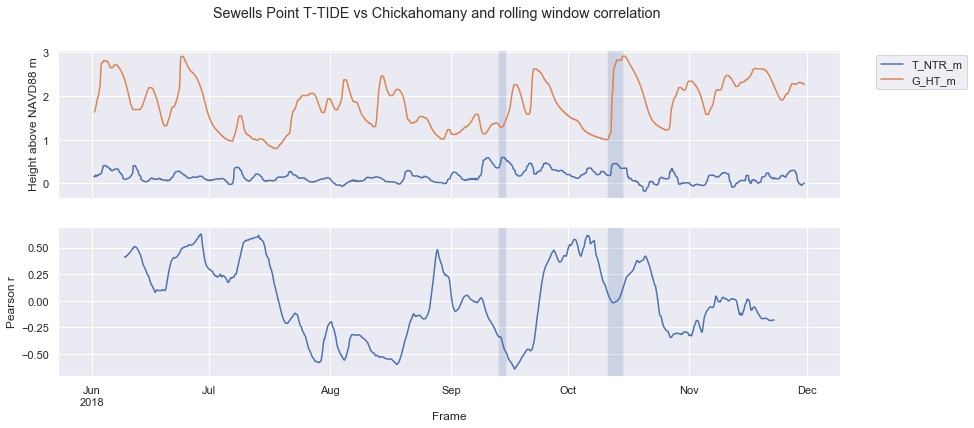

In [432]:
cols_plot = ['T_NTR_m', 'G_HT_m']
title = "Sewells Point T-TIDE vs Chickahomany and rolling window correlation"
rolling_pearson_plot(df_SP, cols_plot, SP_T_rolling_r, title)

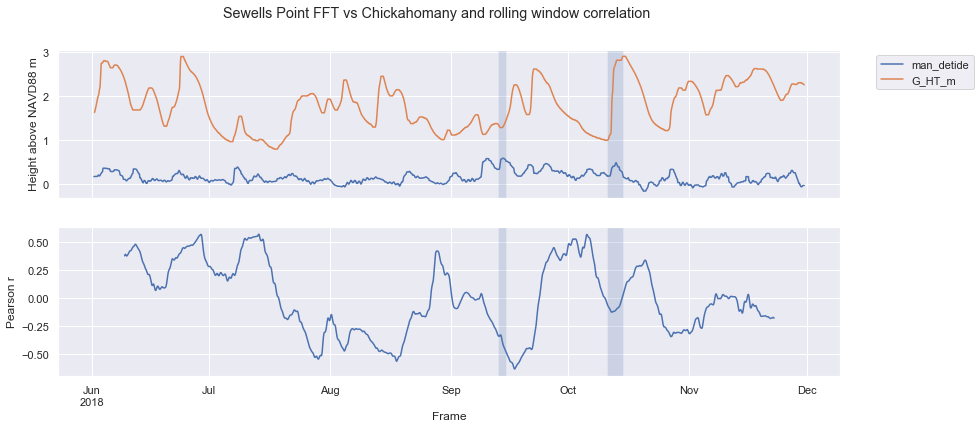

In [433]:
cols_plot = ['man_detide', 'G_HT_m']
title = "Sewells Point FFT vs Chickahomany and rolling window correlation"
rolling_pearson_plot(df_SP, cols_plot, SP_Man_rolling_r, title)

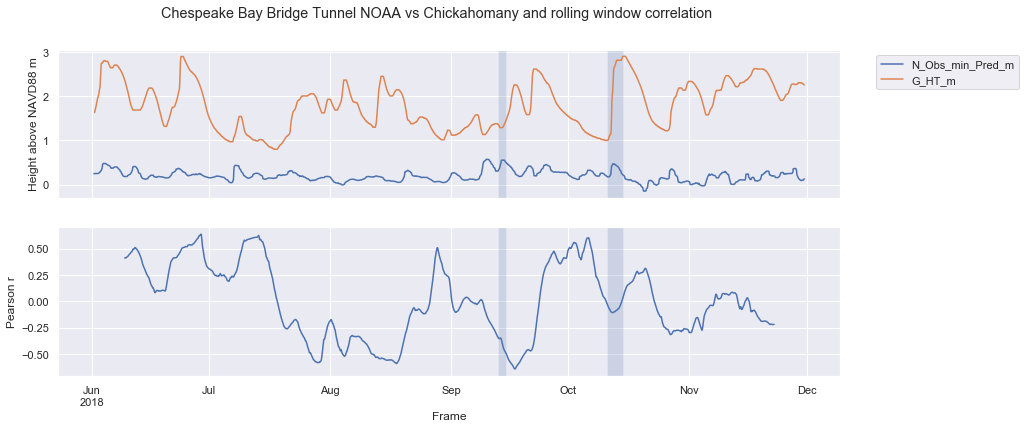

In [434]:
cols_plot = ['N_Obs_min_Pred_m', 'G_HT_m']
title = "Chespeake Bay Bridge Tunnel NOAA vs Chickahomany and rolling window correlation"
rolling_pearson_plot(df_CBBT, cols_plot, CBBT_NOAA_rolling_r, title)

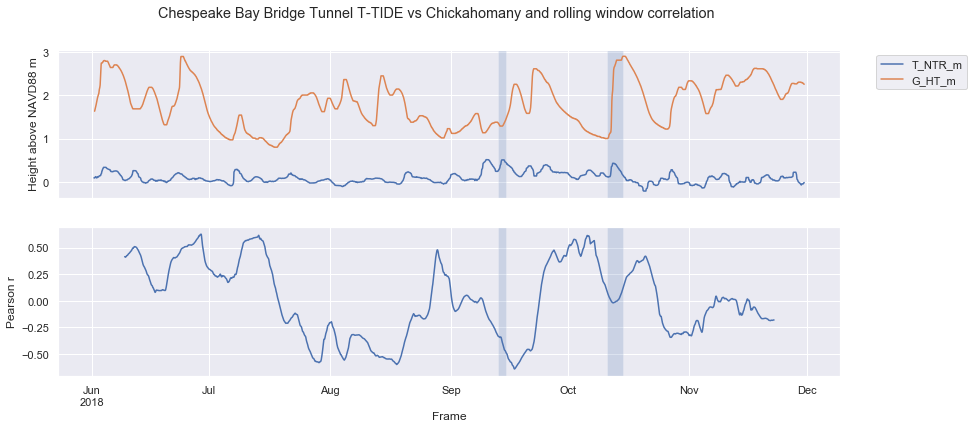

In [435]:
cols_plot = ['T_NTR_m', 'G_HT_m']
title = "Chespeake Bay Bridge Tunnel T-TIDE vs Chickahomany and rolling window correlation"
rolling_pearson_plot(df_CBBT, cols_plot, CBBT_T_rolling_r, title)

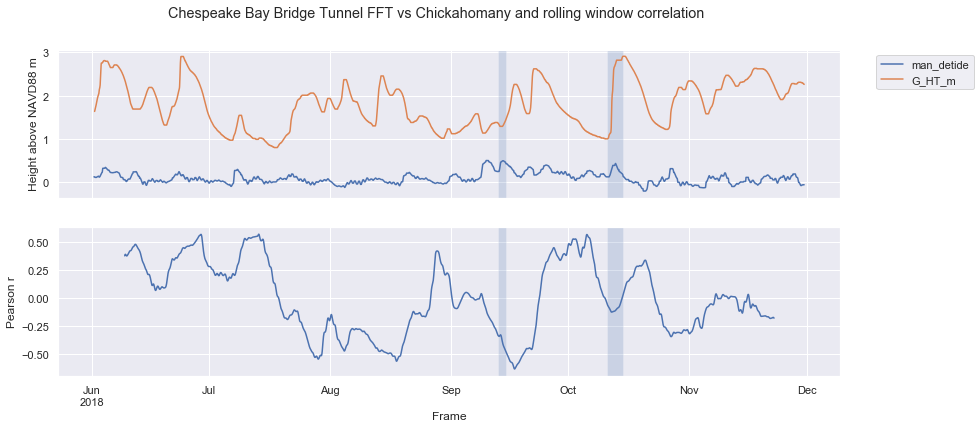

In [281]:
cols_plot = ['man_detide', 'G_HT_m']
title = "Chespeake Bay Bridge Tunnel FFT vs Chickahomany and rolling window correlation"
rolling_pearson_plot(df_CBBT, cols_plot, CBBT_Man_rolling_r, title)

### Time lagged cross correlation

##### This works, need to do it at a smaller time frame, do for hurricane michael

In [445]:
def cross_cor_Michael(df, target1, target2):
    df_Michael = pd.DataFrame(df.loc['2018-10-09':'2018-10-14'])

    npts = len(df_Michael)

    x = df_Michael.index
    y1 = df_Michael[target1]
    y2 = df_Michael[target2]

    lags = np.arange(-npts + 1, npts)
    ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
    ccor = ccov / (npts * y1.std() * y2.std())
    
    maxlag = lags[np.argmax(ccor)]

    fig, axs = plt.subplots(nrows=2)
    fig.subplots_adjust(hspace=0.5)

    ax = axs[0]
    ax.plot(x, y1, 'b', label='y1')
    ax.plot(x, y2, 'r', label='hey')
    ax.set_ylim(0, 4)
    ax.set_ylabel('Water Elevation (m)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.legend(['NTR', 'Gauge Height'],loc='upper left', fontsize='small', ncol=2)

    ax = axs[1]
    ax.plot(lags, ccor)
    ax.set_ylim(-1.1, 1.1)
    plt.axvline(maxlag, alpha = 0.5)
    ax.set_ylabel('cross-correlation')
    ax.set_xlabel('lag of NTR relative to Gauge Height')

    print("max correlation is at lag %d" % maxlag)

    

max correlation is at lag -8


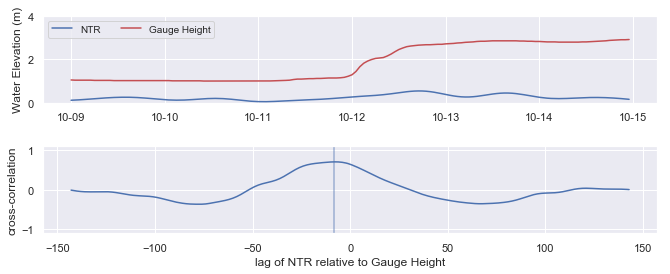

In [446]:
cross_cor_Michael(df_CBBT, 'man_detide', 'G_HT_m')

max correlation is at lag -10


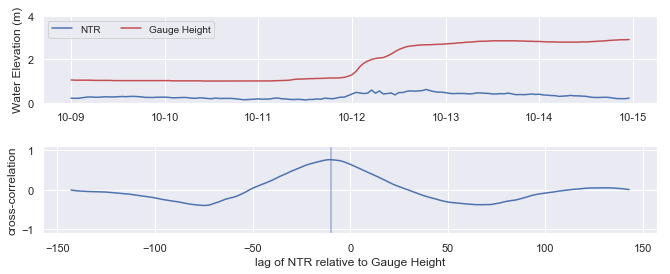

In [447]:
cross_cor_Michael(df_CBBT, 'N_Obs_min_Pred_m', 'G_HT_m')

max correlation is at lag -9


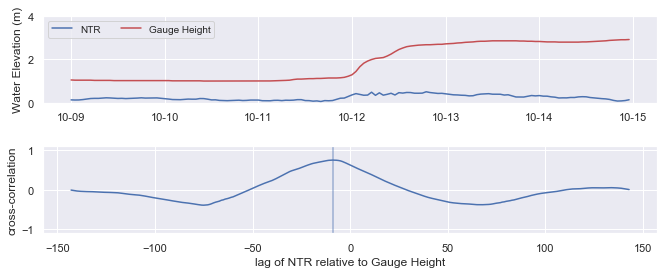

In [448]:
cross_cor_Michael(df_CBBT, 'T_NTR_m', 'G_HT_m')

max correlation is at lag -5


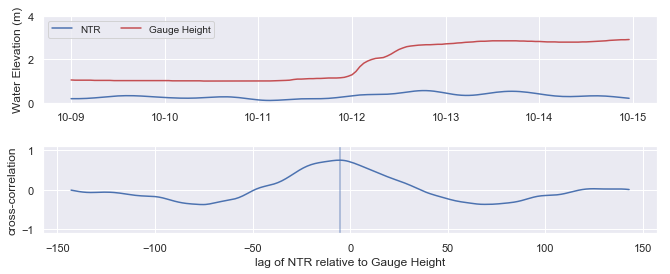

In [449]:
cross_cor_Michael(df_SP, 'man_detide', 'G_HT_m')

max correlation is at lag -9


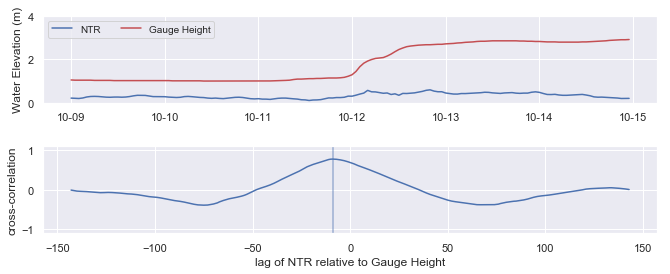

In [450]:
cross_cor_Michael(df_SP, 'N_Obs_min_Pred_m', 'G_HT_m')

max correlation is at lag -7


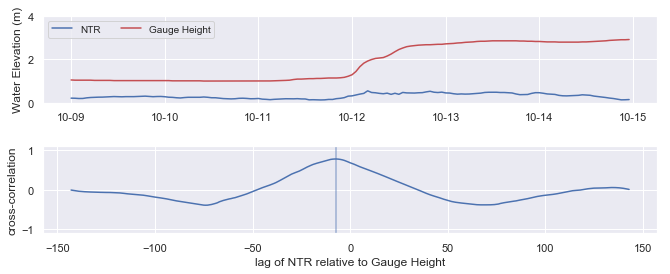

In [451]:
cross_cor_Michael(df_SP, 'T_NTR_m', 'G_HT_m')

In [425]:
def cross_cor_Florence(df, target1, target2):
    df_Florence = pd.DataFrame(df.loc['2018-09-10':'2018-09-20'])

    npts = len(df_Florence)

    x = df_Florence.index
    y1 = df_Florence[target1]
    y2 = df_Florence[target2]

    lags = np.arange(-npts + 1, npts)
    ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
    ccor = ccov / (npts * y1.std() * y2.std())
    
    maxlag = lags[np.argmax(ccor)]

    fig, axs = plt.subplots(nrows=2)
    fig.subplots_adjust(hspace=0.5)

    ax = axs[0]
    ax.plot(x, y1, 'b', label='y1')
    ax.plot(x, y2, 'r', label='hey')
    ax.set_ylim(0, 4)
    ax.set_ylabel('Water Elevation (m)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.legend(['NTR', 'Gauge Height'],loc='upper left', fontsize='small', ncol=2)

    ax = axs[1]
    ax.plot(lags, ccor)
    ax.set_ylim(-1.1, 1.1)
    plt.axvline(maxlag, alpha = 0.5)
    ax.set_ylabel('cross-correlation')
    ax.set_xlabel('lag of NTR relative to Gauge Height')

    print("max correlation is at lag %d" % maxlag)

    

max correlation is at lag -173


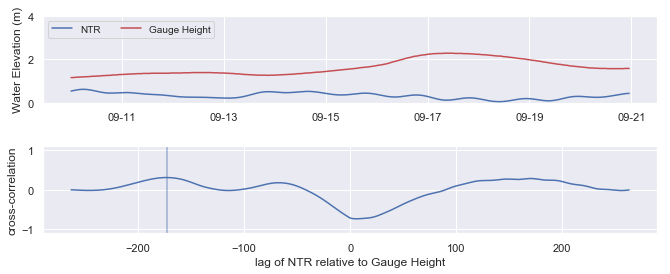

In [426]:
cross_cor_Florence(df_CBBT, 'man_detide', 'G_HT_m')

In [398]:
# df_CBBT_Michael = pd.DataFrame(df_CBBT.loc['2018-10-05':'2018-10-14'])

# npts = len(df_CBBT_Michael)

# x = df_CBBT_Michael.index
# y1 = df_CBBT_Michael['man_detide']
# y2 = df_CBBT_Michael['G_HT_m']

# lags = np.arange(-npts + 1, npts)
# ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
# ccor = ccov / (npts * y1.std() * y2.std())

# fig, axs = plt.subplots(nrows=2)
# fig.subplots_adjust(hspace=0.5)

# ax = axs[0]
# ax.plot(x, y1, 'b', label='y1')
# ax.plot(x, y2, 'r', label='hey')
# ax.set_ylim(0, 4)
# ax.set_ylabel('Water Elevation (m)')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
# ax.legend(['FFT NTR', 'Gauge Height'],loc='upper left', fontsize='small', ncol=2)

# ax = axs[1]
# ax.plot(lags, ccor)
# ax.set_ylim(-1.1, 1.1)
# plt.axvline(-8, alpha = 0.5)
# ax.set_ylabel('cross-correlation')
# ax.set_xlabel('lag of FFT NTR relative to Gauge Height')

# maxlag = lags[np.argmax(ccor)]
# print("max correlation is at lag %d" % maxlag)


In [399]:
# def crosscorr(datax, datay, lag=0, wrap=False):
#     """ Lag-N cross correlation. 
#     Shifted data filled with NaNs 
    
#     Parameters
#     ----------
#     lag : int, default 0
#     datax, datay : pandas.Series objects of equal length
#     Returns
#     ----------
#     crosscorr : float
#     """
#     if wrap:
#         shiftedy = datay.shift(lag)
#         shiftedy.iloc[:lag] = datay.iloc[-lag:].values
#         return datax.corr(shiftedy)
#     else: 
#         return datax.corr(datay.shift(lag))

# d1 = df_SP['N_Obs_min_Pred_m']
# d2 = df_SP['G_HT_m']
# seconds = 5
# fps = 30
# rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
# offset = np.ceil(len(rs)/2)-np.argmax(rs)
# f,ax=plt.subplots(figsize=(14,3))
# ax.plot(rs)
# ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
# ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
# ax.set(title=f'Offset = {offset} frames\nSurge leads <> Riverine leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
# ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
# ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
# plt.legend()

In the plot above, we can infer from the negative offset that Subject 1 (N_Obs_min_Pred_m) is leading the interaction (correlation is maximized when G_HT_m is pulled forward). But once again this assesses signal dynamics at a global level.

In [400]:
# fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
# ax1.xcorr(df_CBBT['man_detide'], df_CBBT['G_HT_m'], usevlines=True, lw=2)
# ax1.grid(True)

# ax2.acorr(df_CBBT['man_detide'], usevlines=True,lw=2)
# ax2.grid(True)

# plt.show()


# #plt.xcorr(df_CBBT['man_detide'], df_CBBT['G_HT_m'])

In [401]:
# nx = 4392
# x = df_CBBT['G_HT_m'].values # normal RV

# lags = np.arange(-nx + 1, nx) # so last value is nx - 1

# # Remove sample mean.
# xdm = x - x.mean()

# autocorr_xdm = np.correlate(xdm, xdm, mode='full')
# # # Normalize by the zero-lag value:
# autocorr_xdm /= autocorr_xdm[nx - 1]

# fig, ax = plt.subplots()
# ax.plot(lags, autocorr_xdm, 'r')
# ax.set_xlabel('lag')
# ax.set_ylabel('correlation coefficient')
# ax.grid(True)

In [240]:
# from dtw import dtw,accelerated_dtw

# d1 = df_SP['N_Obs_min_Pred_m']
# d2 = df_SP['G_HT_m']
# d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

# plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
# plt.plot(path[0], path[1], 'w')
# plt.xlabel('Subject1')
# plt.ylabel('Subject2')
# plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
# plt.show()
